In [2]:
%pip install gymnasium gym matplotlib numpy pandas 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# imports
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

In [4]:
# import the blackjack environment
name = 'Blackjack-v1'
env = gym.make(name) # warning: setting slippery=True results in very complex environment dynamics where the optimal solution does not make sense to humans!

## Implementacion de una politica

In [ ]:
def politica_aleatoria(estado):
    # Acción aleatoria: 0 = Stick, 1 = Hit
    return random.choice([0, 1])

## Simular un episodio

In [ ]:

def simular_episodio(env, politica=None, render=False):
    estados = []
    acciones = []
    recompensas = []
    estado, _ = env.reset()
    terminado = False

    while not terminado:
        if render:
            env.render()
        if politica is not None:
            accion = politica(estado)
        else:
            accion = env.action_space.sample()
        nuevo_estado, recompensa, terminado, _, _ = env.step(accion)
        estados.append(estado)
        acciones.append(accion)
        recompensas.append(recompensa)
        estado = nuevo_estado

    return estados, acciones, recompensas

## Estimar el valor de Q(s, a)

In [ ]:

def estimar_Q(env, politica, num_episodios=500000):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    retornos = defaultdict(list)

    for _ in range(num_episodios):
        estados, acciones, recompensas = simular_episodio(env, politica)
        G = 0
        visitados = set()
        for t in reversed(range(len(estados))):
            G += recompensas[t]
            par = (estados[t], acciones[t])
            if par not in visitados:
                visitados.add(par)
                retornos[par].append(G)
                Q[estados[t]][acciones[t]] = np.mean(retornos[par])
    return Q


## Seleccionar la politica basado en greedy

In [ ]:
def politica_greedy(Q):
    def policy_fn(estado):
        if estado in Q:
            return np.argmax(Q[estado])
        else:
            return random.choice([0, 1])
    return policy_fn

## Evaluar la politica

In [15]:
def evaluar_politica(env, politica, num_episodios=10000):
    ganancias = []
    for _ in range(num_episodios):
        _, _, recompensas = simular_episodio(env, politica)
        ganancias.append(sum(recompensas))
    return np.mean(ganancias)


## Graficas

In [ ]:
def imprimir_politica(policy_actions, iteration=0):
    print(f"Iteración: {iteration}\n"+ "\n  ".join([f"Estado: {estado}, Acción: {accion}" for estado, accion in policy_actions.items()]))
    
def evolucion_por_estado(Q, evaluacion_cada=5000):
    player_sums = np.arange(12, 22)
    dealer_cards = np.arange(1, 11)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    for idx, usable_ace in enumerate([False, True]):
        policy = np.zeros((len(player_sums), len(dealer_cards)))
        for i, player in enumerate(player_sums):
            for j, dealer in enumerate(dealer_cards):
                state = (player, dealer, usable_ace)
                if state in Q:
                    policy[i, j] = np.argmax(Q[state])
                else:
                    policy[i, j] = np.nan  # Estado no visitado
        ax = axes[idx]
        cax = ax.matshow(policy, cmap=plt.cm.coolwarm, vmin=0, vmax=1)
        ax.set_title(f"As usable: {usable_ace}")
        ax.set_xlabel("Carta del dealer")
        ax.set_ylabel("Suma del jugador")
        ax.set_xticks(np.arange(len(dealer_cards)))
        ax.set_yticks(np.arange(len(player_sums)))
        ax.set_xticklabels(dealer_cards)
        ax.set_yticklabels(player_sums)
    fig.colorbar(cax, ax=axes, orientation='vertical', label='Acción óptima (0=Stick, 1=Hit)')
    plt.suptitle("Política óptima aprendida por estado")
    plt.show()
    
def plot_blackjack_policy_surface(Q, usable_ace=True):
    player_sums = np.arange(12, 22)
    dealer_cards = np.arange(1, 11)
    X, Y = np.meshgrid(player_sums, dealer_cards)
    Z = np.zeros_like(X, dtype=float)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            state = (X[i, j], Y[i, j], usable_ace)
            if state in Q:
                Z[i, j] = np.argmax(Q[state])
            else:
                Z[i, j] = np.nan

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='green')
    ax.set_xlabel('Suma del jugador')
    ax.set_ylabel('Carta del dealer')
    ax.set_zlabel('Política (0=Stick, 1=Hit)')
    ax.set_title(f'Política óptima (As usable: {usable_ace})')
    plt.show()

## Prueba

In [26]:
# Política inicial aleatoria
Q = estimar_Q(env, politica_aleatoria, num_episodios=1000000)

# Mejor política encontrada
politica_optima = politica_greedy(Q)

# Evaluar política
rendimiento = evaluar_politica(env, politica_optima)
print(f"Rendimiento promedio de la política óptima: {rendimiento}")

Rendimiento promedio de la política óptima: -0.0995


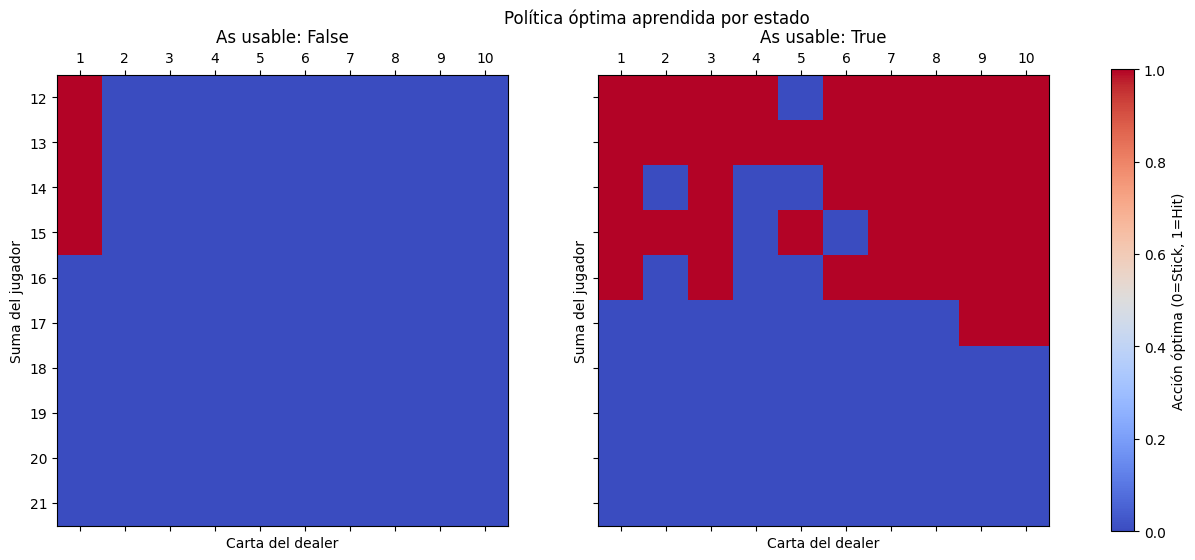

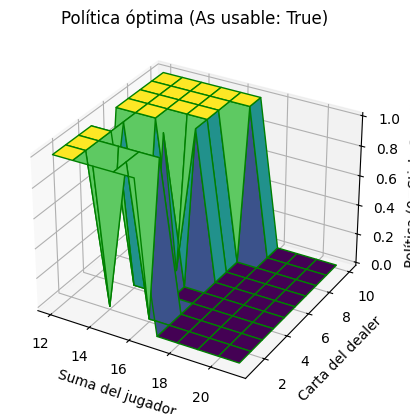

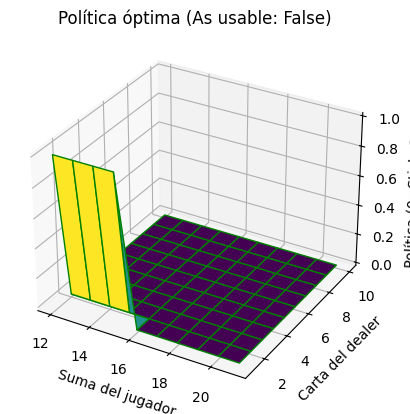

In [ ]:
evolucion_por_estado(Q)
plot_blackjack_policy_surface(Q, usable_ace=True)
plot_blackjack_policy_surface(Q, usable_ace=False)

